In [16]:
# Get all the modules into our path.
import sys
sys.path.insert(0,'/Users/thomasdodd/Library/CloudStorage/OneDrive-MillfieldEnterprisesLimited/github/Omphalos')
sys.path.insert(1,'/Users/thomasdodd/Library/CloudStorage/OneDrive-MillfieldEnterprisesLimited/github')

# Import machine learning modules.
from omphalos import file_methods as fm
from omphalos import attributes as attr
from omphalos import labels as lbls
import analysis as ana
from analysis import helper as hp

# Import data processing modules.
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib as mpl
# Import some extra modules
import re
# Import data visualisation modules.
import matplotlib.pyplot as plt
import seaborn as sns

In [17]:
# Port in and unpack all the runs we need from the .pkl file.
train_set = fm.unpickle('/Users/thomasdodd/Library/CloudStorage/OneDrive-MillfieldEnterprisesLimited/cambridge/ai4er/easter/mres/CrunchFlow_Work/bcm/2022-05-27_bcm_4-0/basalt_na+.pkl')
# Filter any error filled runs
dataset, error = hp.filter_errors(train_set)

Returned 2471 files without errors out of a total possible 5000.
2529 files had errors.
0 files had unhandled errors.
File failure rate: 102.34722784297855 %.
To see unhandled errors, run with verbose=True.


In [45]:
df = attr.get_condition(dataset, "basalt")
df

""


In [18]:
# Scan for errors that are happening
# 0 = successful run
# 1 = timeout
# 2 = condition speciation error
# 3 = charge balance error
# 4 = singular matrix encountered
zeros = 0
ones = 0
twos = 0
threes = 0
fours = 0
for i in error:
    if error[i].error_code == 0:
        zeros += 0
    if error[i].error_code == 1:
        ones += 1
    if error[i].error_code == 2:
        twos += 2
    if error[i].error_code == 3:
        threes += 3
    if error[i].error_code ==4:
        fours += 4
print(f"Successful Runs: {zeros}")
print(f"Timeouts: {ones}")
print(f"Condition Speciation Errors: {twos}")
print(f"Charge Balance Errors: {threes}")
print(f"Singular Matrix Encountered: {fours}")

Successful Runs: 0
Timeouts: 0
Condition Speciation Errors: 0
Charge Balance Errors: 7587
Singular Matrix Encountered: 0


In [19]:
attributes = attr.get_condition(dataset,"basalt",species_concs=True)
attributes = attributes.loc[:, ['Ca++', 'Fe++', 'Mg++', 'HCO3-']]
attributes

/Users/thomasdodd/Library/CloudStorage/OneDrive-MillfieldEnterprisesLimited/github/Omphalos/omphalos/attributes.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  species_attrs = species_attrs.append(primary_species(data_set[i], condition), ignore_index=True)


,Ca++,Fe++,Mg++,HCO3-
0,0.000030,0.000262,0.000121,0.82
1,0.000071,0.000244,0.000245,0.82
2,0.000183,0.000048,0.000124,0.82
3,0.000157,0.000085,0.000127,0.82
4,0.000053,0.000019,0.000237,0.82
...,...,...,...,...
2466,0.000202,0.000091,0.000142,0.82
2467,0.000247,0.000243,0.000007,0.82
2468,0.000117,0.000238,0.000113,0.82
2469,0.000054,0.000160,0.000098,0.82


In [20]:
def NrFormatFixer_XYZTime(xr_DataSet):
    for _ in xr_DataSet.X.values:
        for __ in xr_DataSet.Y.values:
            for ___ in xr_DataSet.Z.values:
                for ____ in xr_DataSet.time.values:
                    for _____ in xr_DataSet.data_vars:
                        xr_DataArray = xr_DataSet[f'{_____}'].loc[dict(X=f'{_}',Y=f'{__}',Z=f'{___}',time=f'{____}')]
                        for ______ in range(0,len(xr_DataArray)):
                            string = str(xr_DataArray.values[______])
                            new_val = string
                            if re.match("^\d+\.\d+-\d+$",string):
                                i_rev = 1
                                str_len = len(string)
                                for _______ in reversed(string):
                                    if _______ == "-":
                                        break
                                    else:
                                        i_rev+=1
                                        continue
                                i = str_len - i_rev
                                new_string = string[:i] + "e" + string[i:]
                                new_val = new_string
                            xr_DataArray.values[______] = new_val
    return xr_DataSet

In [21]:
def NrFormatFixer_XYZ(xr_DataSet):
    for _ in xr_DataSet.X.values:
        for __ in xr_DataSet.Y.values:
            for ___ in xr_DataSet.Z.values:
                for _____ in xr_DataSet.data_vars:
                    xr_DataArray = xr_DataSet[f'{_____}'].loc[dict(X=f'{_}',Y=f'{__}',Z=f'{___}')]
                    for ______ in range(0,len(xr_DataArray)):
                        string = str(xr_DataArray.values[______])
                        new_val = string
                        if re.match("^\d+\.\d+-\d+$",string):
                            i_rev = 1
                            str_len = len(string)
                            for _______ in reversed(string):
                                if _______ == "-":
                                    break
                                else:
                                    i_rev+=1
                                    continue
                            i = str_len - i_rev
                            new_string = string[:i] + "e" + string[i:]
                            new_val = new_string
                        xr_DataArray.values[______] = new_val
    return xr_DataSet

In [22]:
final_vols = lbls.raw(dataset, 'volume')
final_vols = NrFormatFixer_XYZTime(final_vols)
final_vols = final_vols.astype(float)

In [23]:
initial_vols = attr.initial_conditions(dataset, concentrations=False, minerals=True)
initial_vols = NrFormatFixer_XYZ(initial_vols)
initial_vols = initial_vols.astype(float)

In [24]:
delt_vf = final_vols - initial_vols
delt_vf

<xarray.Dataset>
Dimensions:       (X: 1, Y: 1, Z: 1, time: 28, file_num: 2471)
Coordinates:
  * X             (X) float64 0.5
  * Y             (Y) float64 0.5
  * Z             (Z) float64 0.5
  * time          (time) float64 0.01 0.02 0.03 0.04 0.05 ... 7.0 8.0 9.0 10.0
Dimensions without coordinates: file_num
Data variables:
    Diopside      (file_num, time, X, Y, Z) float64 -5.975e-06 ... 0.0003322
    Hedenbergite  (file_num, time, X, Y, Z) float64 -3.904e-06 ... -0.0003335
    Albite        (file_num, time, X, Y, Z) float64 1.546e-05 ... 3.703e-05
    Anorthite     (file_num, time, X, Y, Z) float64 -2.794e-06 ... -1.366e-05
    M_Microcline  (file_num, time, X, Y, Z) float64 1.89e-07 ... 2.21e-07
    Forsterite    (file_num, time, X, Y, Z) float64 -0.0002667 ... -0.001728
    Fayalite      (file_num, time, X, Y, Z) float64 -0.0001294 ... 5.107e-05
    Calcite       (file_num, time, X, Y, Z) float64 -8.931e-11 ... -1e-10
    Magnesite     (file_num, time, X, Y, Z) float64 1.917e-12 ... 0.001867
    Siderite      (file_num, time, X, Y, Z) float64 0.0001662 ... 7.946e-05

In [25]:
delt_vf_TenYr = delt_vf.sel(X=0.5,Y=0.5,Z=0.5,time=10)
delt_vf_TenYr

<xarray.Dataset>
Dimensions:       (file_num: 2471)
Coordinates:
    X             float64 0.5
    Y             float64 0.5
    Z             float64 0.5
    time          float64 10.0
Dimensions without coordinates: file_num
Data variables:
    Diopside      (file_num) float64 0.0003505 0.0003612 ... 0.0003218 0.0003322
    Hedenbergite  (file_num) float64 -0.0003315 -0.0003304 ... -0.0003335
    Albite        (file_num) float64 9.903e-05 0.0001341 ... 2.889e-06 3.703e-05
    Anorthite     (file_num) float64 -4.482e-05 -6.244e-05 ... -1.366e-05
    M_Microcline  (file_num) float64 2.2e-07 2.2e-07 ... 2.21e-07 2.21e-07
    Forsterite    (file_num) float64 -0.001725 -0.001723 ... -0.00173 -0.001728
    Fayalite      (file_num) float64 5.12e-05 5.127e-05 ... 5.111e-05 5.107e-05
    Calcite       (file_num) float64 -1e-10 -1e-10 -1e-10 ... -1e-10 -1e-10
    Magnesite     (file_num) float64 0.001868 0.001869 ... 0.001868 0.001867
    Siderite      (file_num) float64 7.847e-05 7.784e-05 ... 7.962e-05 7.946e-05

In [26]:
delt_vf_TenYr = delt_vf_TenYr.assign(Carbonates=lambda delt_vf_TenYr: delt_vf_TenYr.Calcite + delt_vf_TenYr.Siderite + delt_vf_TenYr.Magnesite)
delt_vf_TenYr

<xarray.Dataset>
Dimensions:       (file_num: 2471)
Coordinates:
    X             float64 0.5
    Y             float64 0.5
    Z             float64 0.5
    time          float64 10.0
Dimensions without coordinates: file_num
Data variables:
    Diopside      (file_num) float64 0.0003505 0.0003612 ... 0.0003218 0.0003322
    Hedenbergite  (file_num) float64 -0.0003315 -0.0003304 ... -0.0003335
    Albite        (file_num) float64 9.903e-05 0.0001341 ... 2.889e-06 3.703e-05
    Anorthite     (file_num) float64 -4.482e-05 -6.244e-05 ... -1.366e-05
    M_Microcline  (file_num) float64 2.2e-07 2.2e-07 ... 2.21e-07 2.21e-07
    Forsterite    (file_num) float64 -0.001725 -0.001723 ... -0.00173 -0.001728
    Fayalite      (file_num) float64 5.12e-05 5.127e-05 ... 5.111e-05 5.107e-05
    Calcite       (file_num) float64 -1e-10 -1e-10 -1e-10 ... -1e-10 -1e-10
    Magnesite     (file_num) float64 0.001868 0.001869 ... 0.001868 0.001867
    Siderite      (file_num) float64 7.847e-05 7.784e-05 ... 7.962e-05 7.946e-05
    Carbonates    (file_num) float64 0.001946 0.001946 ... 0.001947 0.001947

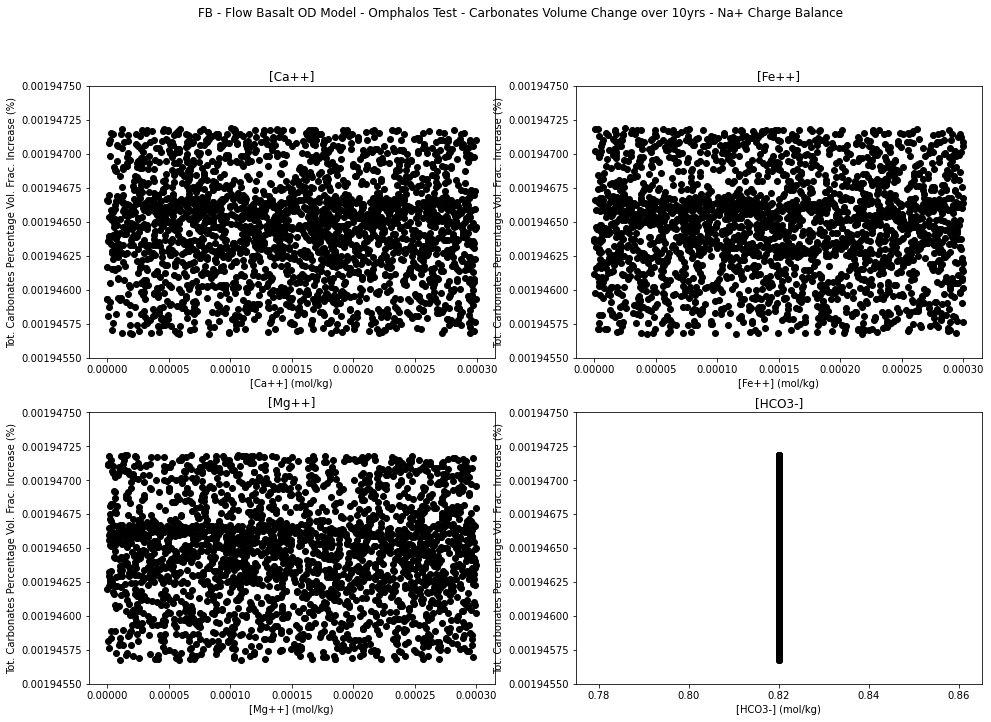

In [47]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2)
fig.suptitle('FB - Flow Basalt OD Model - Omphalos Test - Carbonates Volume Change over 10yrs - Na+ Charge Balance')

fig.set_figheight(11)
fig.set_figwidth(16)

ax1.set_title("[Ca++]")
ax2.set_title("[Fe++]")
ax3.set_title("[Mg++]")
ax4.set_title("[HCO3-]")
ax1.set_ylabel('Tot. Carbonates Percentage Vol. Frac. Increase (%)')
ax2.set_ylabel('Tot. Carbonates Percentage Vol. Frac. Increase (%)')
ax3.set_ylabel('Tot. Carbonates Percentage Vol. Frac. Increase (%)')
ax4.set_ylabel('Tot. Carbonates Percentage Vol. Frac. Increase (%)')
ax1.set_xlabel('[Ca++] (mol/kg)')
ax2.set_xlabel('[Fe++] (mol/kg)')
ax3.set_xlabel('[Mg++] (mol/kg)')
ax4.set_xlabel('[HCO3-] (mol/kg)')
ax1.set_ylim(bottom=0.0019455, top=0.0019475)
ax2.set_ylim(bottom=0.0019455, top=0.0019475)
ax3.set_ylim(bottom=0.0019455, top=0.0019475)
ax4.set_ylim(bottom=0.0019455, top=0.0019475)

for x_value,run_number,y_value in zip(attributes["Ca++"].values, delt_vf_TenYr.Carbonates.file_num.values, delt_vf_TenYr.Carbonates.values):
    ax1.plot(x_value, y_value, color='black', marker='o')
for x_value,run_number,y_value in zip(attributes["Fe++"].values, delt_vf_TenYr.Carbonates.file_num.values, delt_vf_TenYr.Carbonates.values):
    ax2.plot(x_value, y_value, color='black', marker='o')
for x_value,run_number,y_value in zip(attributes["Mg++"].values, delt_vf_TenYr.Carbonates.file_num.values, delt_vf_TenYr.Carbonates.values):
    ax3.plot(x_value, y_value, color='black', marker='o')
for x_value,run_number,y_value in zip(attributes["HCO3-"].values, delt_vf_TenYr.Carbonates.file_num.values, delt_vf_TenYr.Carbonates.values):
    ax4.plot(x_value, y_value, color='black', marker='o')

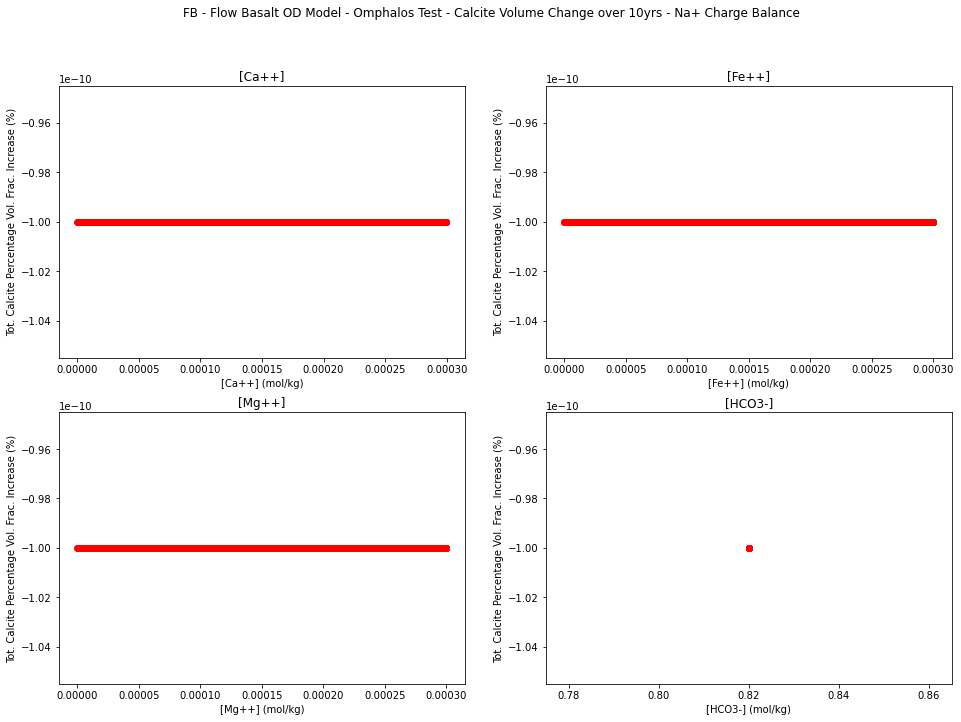

In [40]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2)
fig.suptitle('FB - Flow Basalt OD Model - Omphalos Test - Calcite Volume Change over 10yrs - Na+ Charge Balance')

fig.set_figheight(11)
fig.set_figwidth(16)

ax1.set_title("[Ca++]")
ax2.set_title("[Fe++]")
ax3.set_title("[Mg++]")
ax4.set_title("[HCO3-]")
ax1.set_ylabel('Tot. Calcite Percentage Vol. Frac. Increase (%)')
ax2.set_ylabel('Tot. Calcite Percentage Vol. Frac. Increase (%)')
ax3.set_ylabel('Tot. Calcite Percentage Vol. Frac. Increase (%)')
ax4.set_ylabel('Tot. Calcite Percentage Vol. Frac. Increase (%)')
ax1.set_xlabel('[Ca++] (mol/kg)')
ax2.set_xlabel('[Fe++] (mol/kg)')
ax3.set_xlabel('[Mg++] (mol/kg)')
ax4.set_xlabel('[HCO3-] (mol/kg)')
# ax1.set_ylim(bottom=0.0019455, top=0.0019475)
# ax2.set_ylim(bottom=0.0019455, top=0.0019475)
# ax3.set_ylim(bottom=0.0019455, top=0.0019475)
# ax4.set_ylim(bottom=0.0019455, top=0.0019475)

for x_value,run_number,y_value in zip(attributes["Ca++"].values, delt_vf_TenYr.Calcite.file_num.values, delt_vf_TenYr.Calcite.values):
    ax1.plot(x_value, y_value, color='red', marker='o')
for x_value,run_number,y_value in zip(attributes["Fe++"].values, delt_vf_TenYr.Calcite.file_num.values, delt_vf_TenYr.Calcite.values):
    ax2.plot(x_value, y_value, color='red', marker='o')
for x_value,run_number,y_value in zip(attributes["Mg++"].values, delt_vf_TenYr.Calcite.file_num.values, delt_vf_TenYr.Calcite.values):
    ax3.plot(x_value, y_value, color='red', marker='o')
for x_value,run_number,y_value in zip(attributes["HCO3-"].values, delt_vf_TenYr.Calcite.file_num.values, delt_vf_TenYr.Calcite.values):
    ax4.plot(x_value, y_value, color='red', marker='o')

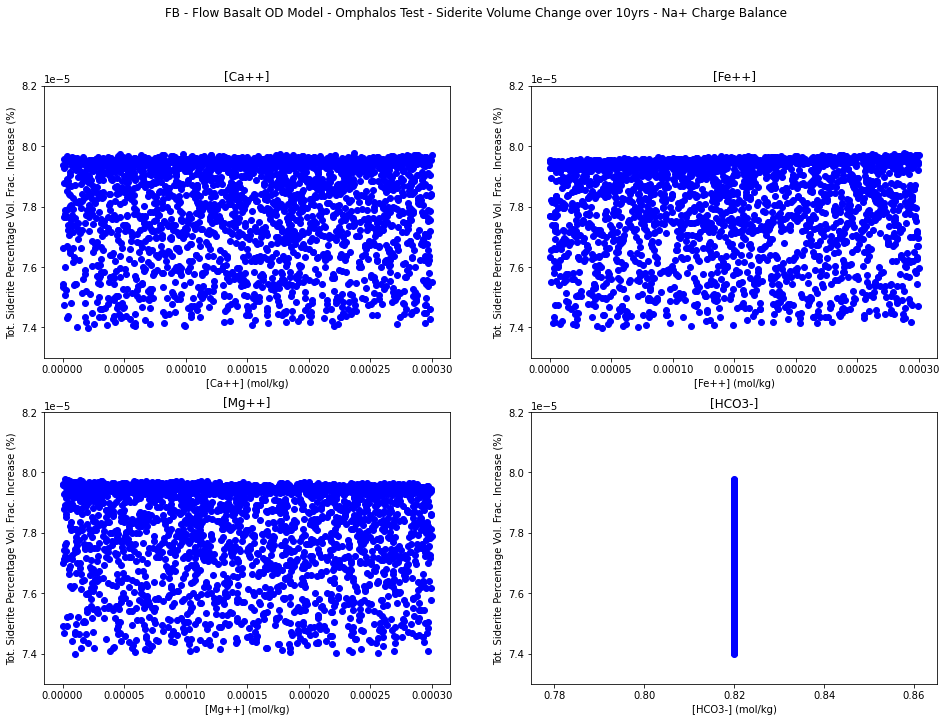

In [43]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2)
fig.suptitle('FB - Flow Basalt OD Model - Omphalos Test - Siderite Volume Change over 10yrs - Na+ Charge Balance')

fig.set_figheight(11)
fig.set_figwidth(16)

ax1.set_title("[Ca++]")
ax2.set_title("[Fe++]")
ax3.set_title("[Mg++]")
ax4.set_title("[HCO3-]")
ax1.set_ylabel('Tot. Siderite Percentage Vol. Frac. Increase (%)')
ax2.set_ylabel('Tot. Siderite Percentage Vol. Frac. Increase (%)')
ax3.set_ylabel('Tot. Siderite Percentage Vol. Frac. Increase (%)')
ax4.set_ylabel('Tot. Siderite Percentage Vol. Frac. Increase (%)')
ax1.set_xlabel('[Ca++] (mol/kg)')
ax2.set_xlabel('[Fe++] (mol/kg)')
ax3.set_xlabel('[Mg++] (mol/kg)')
ax4.set_xlabel('[HCO3-] (mol/kg)')
ax1.set_ylim(bottom=7.3e-5, top=8.2e-5)
ax2.set_ylim(bottom=7.3e-5, top=8.2e-5)
ax3.set_ylim(bottom=7.3e-5, top=8.2e-5)
ax4.set_ylim(bottom=7.3e-5, top=8.2e-5)

for x_value,run_number,y_value in zip(attributes["Ca++"].values, delt_vf_TenYr.Siderite.file_num.values, delt_vf_TenYr.Siderite.values):
    ax1.plot(x_value, y_value, color='blue', marker='o')
for x_value,run_number,y_value in zip(attributes["Fe++"].values, delt_vf_TenYr.Siderite.file_num.values, delt_vf_TenYr.Siderite.values):
    ax2.plot(x_value, y_value, color='blue', marker='o')
for x_value,run_number,y_value in zip(attributes["Mg++"].values, delt_vf_TenYr.Siderite.file_num.values, delt_vf_TenYr.Siderite.values):
    ax3.plot(x_value, y_value, color='blue', marker='o')
for x_value,run_number,y_value in zip(attributes["HCO3-"].values, delt_vf_TenYr.Siderite.file_num.values, delt_vf_TenYr.Siderite.values):
    ax4.plot(x_value, y_value, color='blue', marker='o')

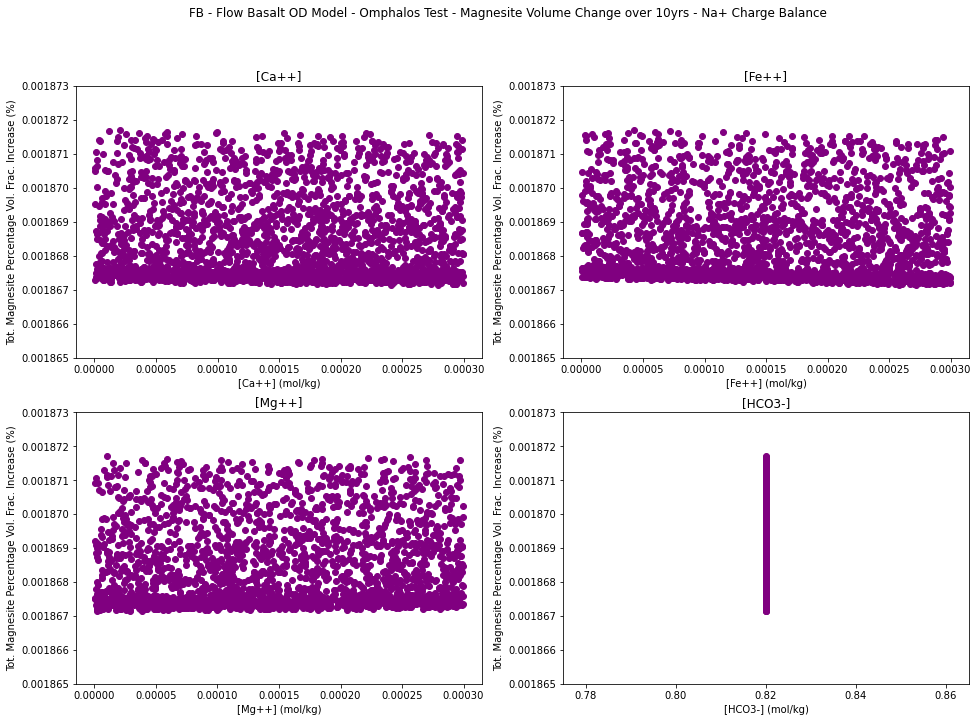

In [44]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2)
fig.suptitle('FB - Flow Basalt OD Model - Omphalos Test - Magnesite Volume Change over 10yrs - Na+ Charge Balance')

fig.set_figheight(11)
fig.set_figwidth(16)

ax1.set_title("[Ca++]")
ax2.set_title("[Fe++]")
ax3.set_title("[Mg++]")
ax4.set_title("[HCO3-]")
ax1.set_ylabel('Tot. Magnesite Percentage Vol. Frac. Increase (%)')
ax2.set_ylabel('Tot. Magnesite Percentage Vol. Frac. Increase (%)')
ax3.set_ylabel('Tot. Magnesite Percentage Vol. Frac. Increase (%)')
ax4.set_ylabel('Tot. Magnesite Percentage Vol. Frac. Increase (%)')
ax1.set_xlabel('[Ca++] (mol/kg)')
ax2.set_xlabel('[Fe++] (mol/kg)')
ax3.set_xlabel('[Mg++] (mol/kg)')
ax4.set_xlabel('[HCO3-] (mol/kg)')
ax1.set_ylim(bottom=0.001865, top=0.001873)
ax2.set_ylim(bottom=0.001865, top=0.001873)
ax3.set_ylim(bottom=0.001865, top=0.001873)
ax4.set_ylim(bottom=0.001865, top=0.001873)

for x_value,run_number,y_value in zip(attributes["Ca++"].values, delt_vf_TenYr.Magnesite.file_num.values, delt_vf_TenYr.Magnesite.values):
    ax1.plot(x_value, y_value, color='purple', marker='o')
for x_value,run_number,y_value in zip(attributes["Fe++"].values, delt_vf_TenYr.Magnesite.file_num.values, delt_vf_TenYr.Magnesite.values):
    ax2.plot(x_value, y_value, color='purple', marker='o')
for x_value,run_number,y_value in zip(attributes["Mg++"].values, delt_vf_TenYr.Magnesite.file_num.values, delt_vf_TenYr.Magnesite.values):
    ax3.plot(x_value, y_value, color='purple', marker='o')
for x_value,run_number,y_value in zip(attributes["HCO3-"].values, delt_vf_TenYr.Magnesite.file_num.values, delt_vf_TenYr.Magnesite.values):
    ax4.plot(x_value, y_value, color='purple', marker='o')